In [75]:
import numpy as np
import json
import itertools
import spglib
import matplotlib.pyplot as plt
import seaborn as sns

In [723]:
def str2mat(s):
    rows = []
    N = len(s.split(','))
    env = {'x': np.array([1,0]), 'y': np.array([0,1])}
    fake_env = {'x': 0, 'y': 0}
    for si in s.split(','):
        r = [0] * N
        l = {}
        # use fake ones to get translation
        exec('f = ' + si.strip(), fake_env, l)
        exec('o = ' + si.strip(),env, l)
        # remove trans and add
        rows.append(np.append(l['o'] - l['f'], l['f']))        
    rows.append(np.array([0,0,1]))
    return np.vstack(rows)

def asymm_constraints(s):
    s = s.replace('≤', '<=')        
    env = {}
    exec('from math import *', env)
    funcs = []
    for i, si in enumerate(s.split(';')):
        l = {}
        exec(f'l{i} = lambda x,y:' + si, env, l)
        funcs.append(l[f'l{i}'])
    return lambda x,y: sum([f(x,y) for f in funcs]) == len(funcs)
    
str2mat('x/6 - y/6, y + 1/2')
asymm_constraints('0 ≤ x ≤ 1/4; 0 ≤ y ≤ 1/2')(0.23, 0.2)

True

In [734]:
#TODO: make it so each input element matters
projectors = {             
    'square': 
    np.array([
        4 * [1/4], 
        4 * [0],
        4 * [0],
        4 * [1/4]
    ]),
    'rectangle': 
    np.array([
        [1/2, 1/2, 0, 0], 
        4 * [0],
        4 * [0],
        [0, 0, 1/2, 1/2]
    ]),
    'hexagon':
    np.array([
        4 * [1/4],
        4 * [0],
        4 * [-1/8],
        4 * [np.sqrt(3)/8]
    ]),
    'mono':np.eye(4),
}

e = 'x,y'
wallpaper_s = {
    'p1': ('mono', [e], '0 ≤ x ≤ 1; 0 ≤ y ≤ 1'), 
    'p2': ('mono', [e, '-x, y'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1'),
    'pm': ('rectangle', [e, '-x, y + 1/2'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1'),
    'cm': ('rectangle', [e, '-x,y', 'x+1/2,y+1/2', '-x+1/2,y+1/2'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1'),
    'pg': ('rectangle', [e, 'x,y', 'x+1/2, y+1/2', '-x+1/2, y+1/2'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2'),
    'pmm': ('rectangle', [e, '-x,-y', '-x,y','x,-y'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2'),
    'pmg': ('rectangle', [e, '-x,-y','-x+1/2, y','x+1/2,-y'], '0 ≤ x ≤ 1/4; 0 ≤ y ≤ 1'),
    'pgg': ('rectangle', [e, '-x,-y', '-x+1/2,y+1/2', 'x+1/2,-y+1/2'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2'),
    'cmm': ('rectangle', [e,'-x,-y', '-x,y', 'x,-y', 'x+1/2,y+1/2',
                       '-x+1/2,-y+1/2', '-x+1/2,y+1/2', 'x+1/2,-y+1/2'], '0 ≤ x ≤ 1/4; 0 ≤ y ≤ 1/2'),
    'p4': ('square', [e, '-x,-y', '-y,x', 'y,-x'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2'),
    'p4mm': ('square', [e, '-x,-y', '-y, x', 'y, -x', '-x,y', 'x,-y', 'y,x', '-y,-x'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2; x ≤ y'),
    'p4gm': ('square', [e, '-x,-y', '-y, x', 'y, -x', '-x+1/2,y+1/2', 'x+1/2,-y+1/2', 'y+1/2,x+1/2', '-y+1/2,-x+1/2'],
            '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2; y ≤ 1/2 - x'),
    'p3': ('hexagon', [e,'-y, x-y', '-x+y,-x'], '0 ≤ x ≤ 2/3; 0 ≤ y ≤ 2/3; x ≤ (1 + y)/2; y ≤ min(1 - x, (1 + x)/2)'),
    'p3m1': ('hexagon', [e,'-y, x-y', '-x+y,-x', '-y,-x', '-x+y,y', 'x,x-y'], '0 ≤ x ≤ 2/3; 0 ≤ y ≤ 2/3; x ≤ (1 + y)/2; y ≤ min(1 - x, (1 + x)/2)'),
    'p31m': ('hexagon', [e,'-y, x-y', '-x+y,-x', 'y,x', 'x-y,-y', '-x,-x+y'], '0 ≤ x ≤ 2/3; 0 ≤ y ≤ 2/3; x ≤ 2*y; y ≤ min(1 - x, 2*x)'),
    'p6': ('hexagon', [e,'-y, x-y', '-x+y,-x', '-x,-y', 'y,-x+y', 'x-y,x'], '0 ≤ x ≤ 2/3; 0 ≤ y ≤ 1/2; x ≤ (1 + y)/2; y ≤ min(1 - x, x)'),
    'p6mm': ('hexagon', [e,'-y, x-y', '-x+y,-x', '-x,-y', 'y,-x+y', 'x-y,x',
                        '-y,-x', '-x+y,y', 'x,x-y', 'y,x', 'x-y,-y', '-x,-x+y'], '0≤ x ≤ 2/3; 0 ≤ y ≤ 1/3; x ≤ (1 + y)/2; y ≤ x/2'),
    
    
}

wallpaper = {k: (projectors[v[0]], [str2mat(s) for s in v[1]], asymm_constraints(v[2])) for k,v in wallpaper_s.items()}

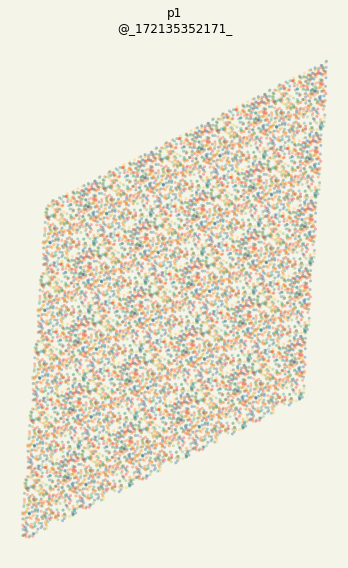

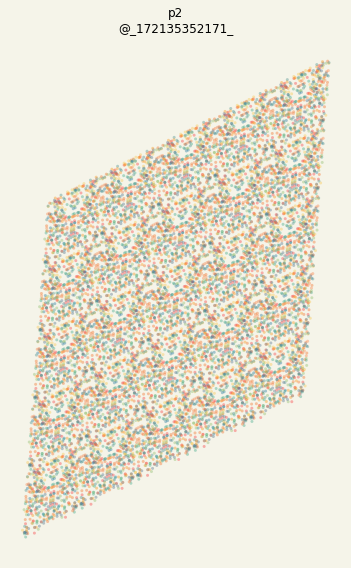

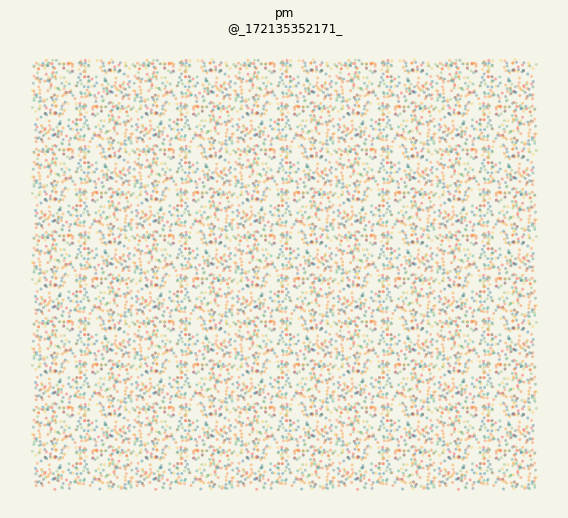

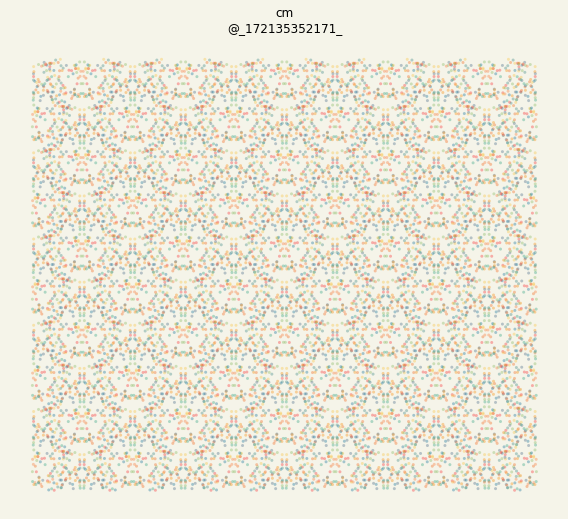

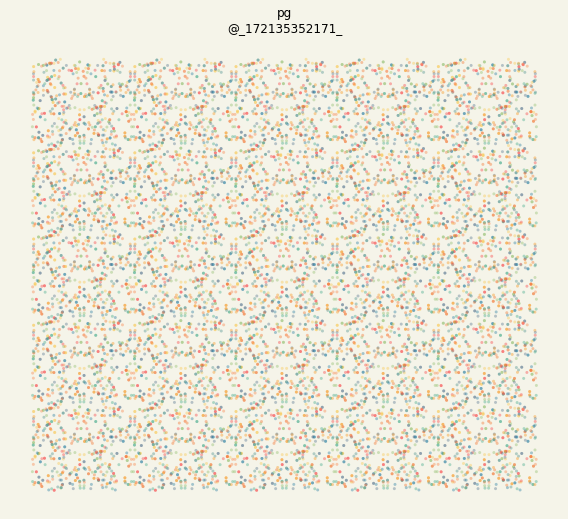

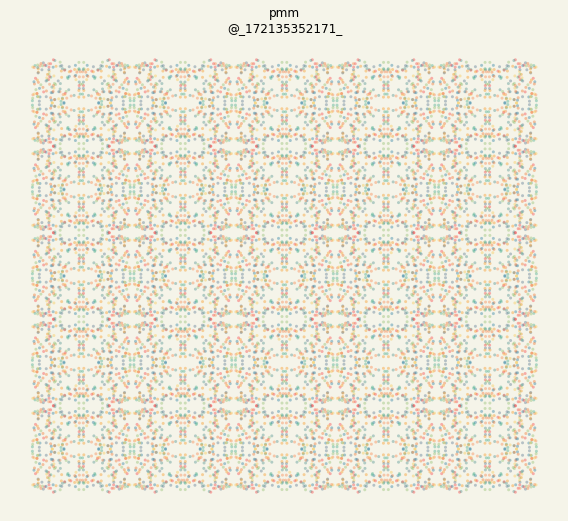

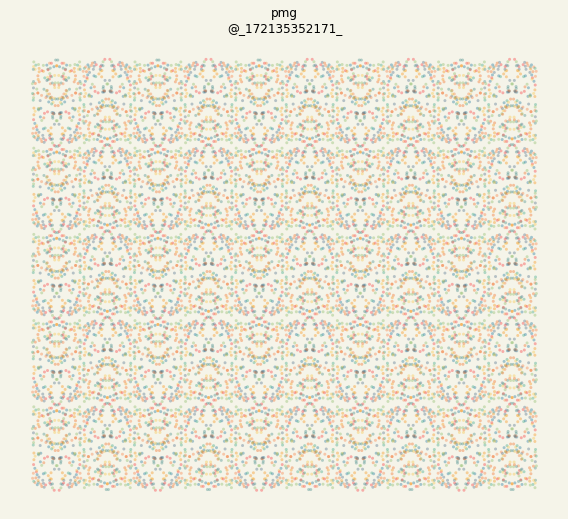

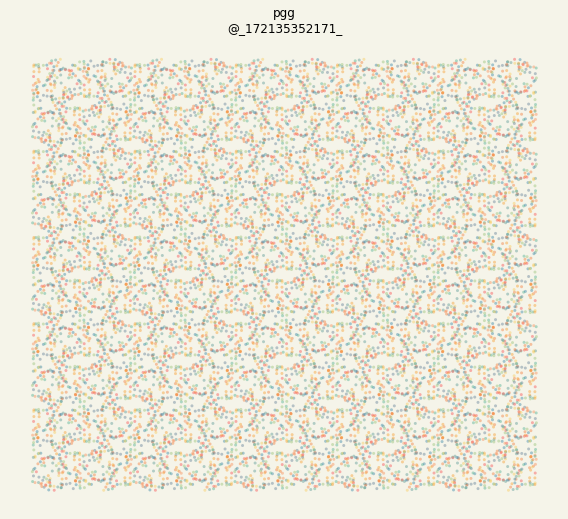

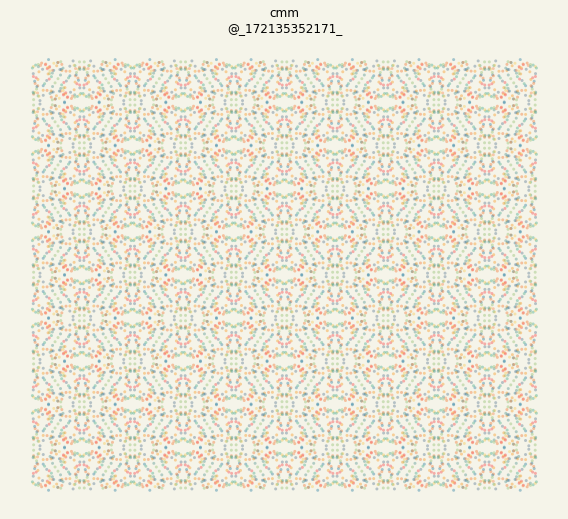

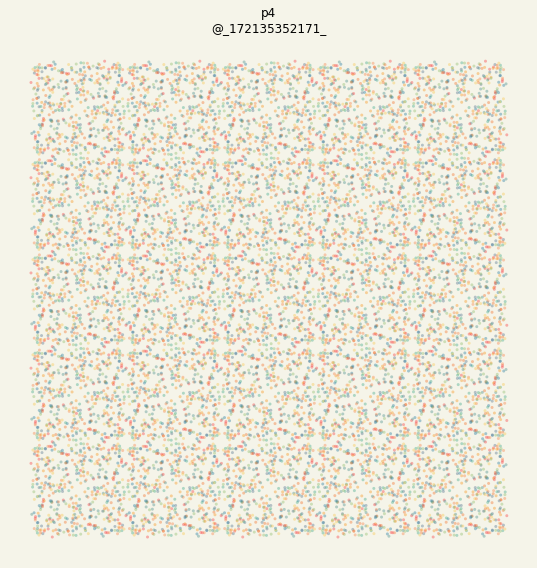

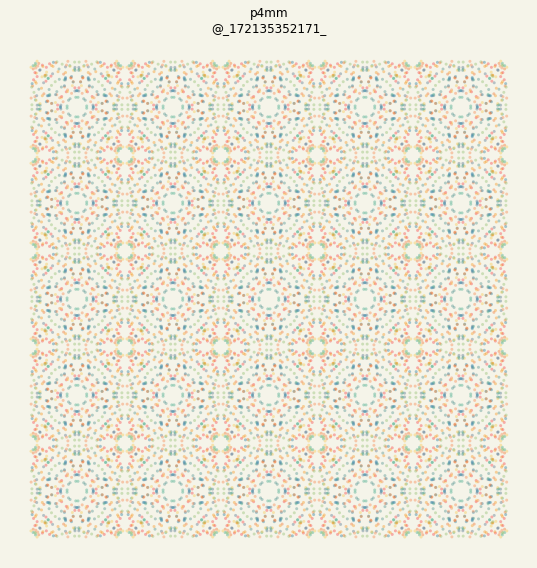

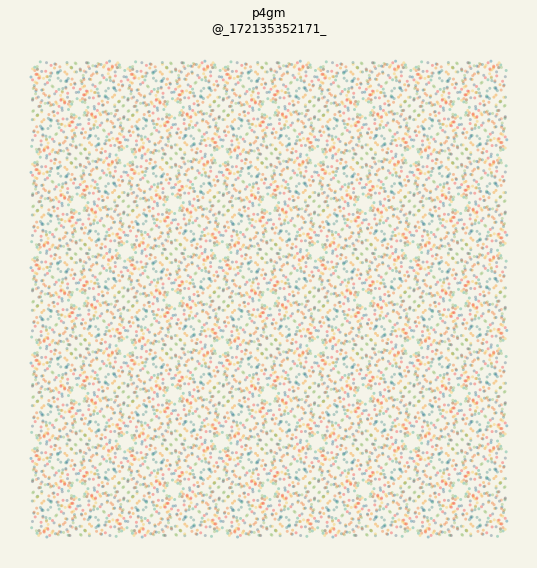

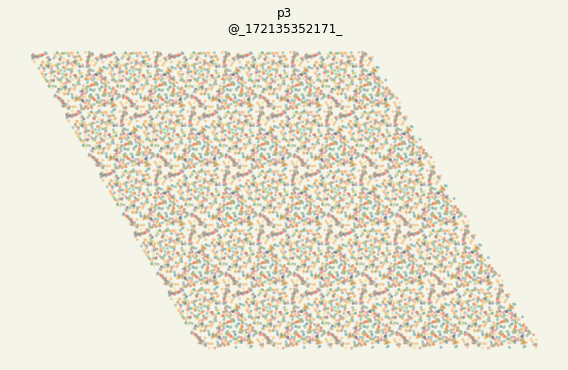

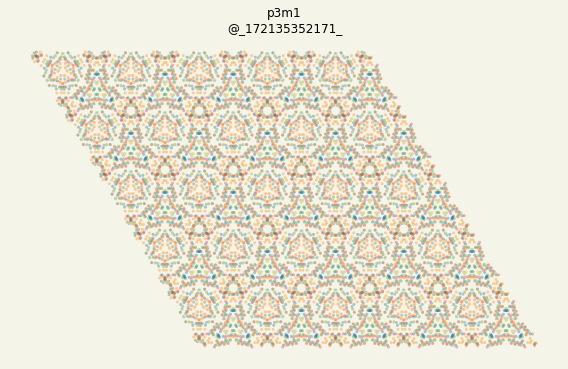

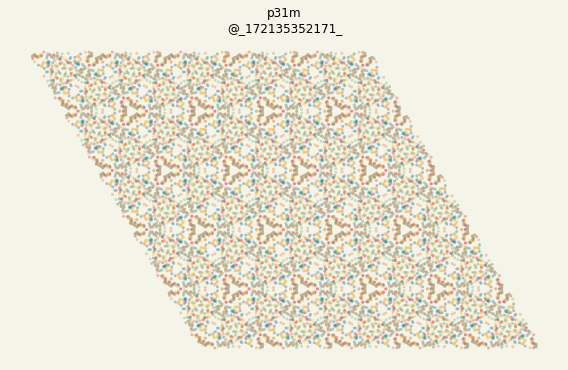

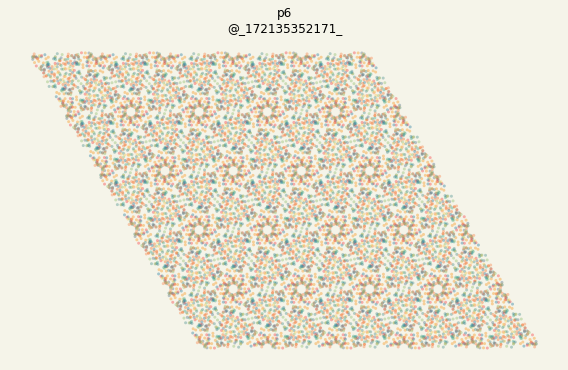

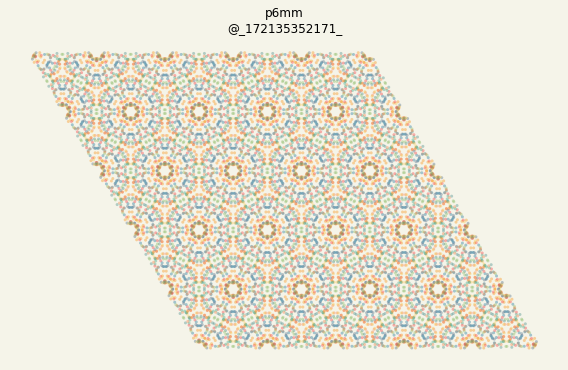

In [743]:
def plot_group(x, basis, g, title, show_basis=False):    
    basis = (g[0] @ basis.flatten()).reshape(basis.shape)    
    if show_basis:
        plt.plot([0, basis[0,0]], [0,basis[0,1]], '-', color='black')
        plt.plot([0, basis[1,0]], [0,basis[1,1]], '-', color='black')
    n = [0, -1, 1, -2, 2]
    # reduce x size to match group
    npoints = x.shape[0] // len(g[1])
    x = x[:npoints, :]    
    points = []
    base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]
    colors = ['#' + base_colors[i % len(base_colors)] for i in range(x.shape[0])]
    #colors = [f'black' for i in range(x.shape[0])]
    for i, ns in enumerate(itertools.product(n, repeat=2)):        
        for w in g[1]:
            xw = np.mod((w @ x.T).T, 1)
            xc = (xw[:,:2] + ns) @ basis            
            plt.scatter(xc[:,0], xc[:,1], c=colors, marker='.', alpha=0.4,  edgecolors='none' )
            points.append(xc[:,:2])
    x = np.vstack(points)
    #sns.kdeplot(x=x[:,0], y=x[:,1], shade=True, bw_adjust=0.2, cmap='Reds')
    if title:
        plt.title(title)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.gca().set_facecolor('#f5f4e9')
    plt.gcf().patch.set_facecolor('#f5f4e9')

def generate_points(x, basis, g):
    basis = (g[0] @ basis.flatten()).reshape(basis.shape)    
    n = [0, -1, 1, -2, 2]
    # reduce x size to match group
    npoints = x.shape[0] // len(g[1])
    x = x[:npoints, :]   
    points = []
    for i, ns in enumerate(itertools.product(n, repeat=2)):        
        for w in g[1]:
            xw = np.mod((w @ x.T).T, 1)
            xc = (xw[:,:2] + ns) @ basis            
            points.append(xc[:,:2])
    x = np.vstack(points)
    return x
np.random.seed(0)
npoints = 24 * 20
x = np.hstack((np.random.uniform(size=(npoints,2)) - 0.5, np.ones((npoints,1))))
basis = np.array([[1,0], [0,1]]) + np.random.uniform(size=(2,2))
for k,v in wallpaper.items():
    plt.figure(figsize=(8,8))
    plot_group(x, basis, v, title=f'{k}\n@_172135352171_')
    plt.tight_layout()
    plt.savefig(k + '.png', dpi=90)

In [738]:
def write_group(f, name, group):
    # tiling code needs to be updated for more than 2D
    def fmt(n):
        return list(np.round(n.astype(float).flatten(), 8))
    projector, members, asymm = group
    result = {'name': name, 'size': len(members), 'members': [], 'projector': fmt(projector)}
    has_identity = False
    for m in members:
        i = np.linalg.inv(m)
        result['members'].append({'g': fmt(m), 'i': fmt(i)})
    json.dump(result, f, indent=True)
    print('Wrote group with', len(members), 'members.')

In [739]:
for k,v in wallpaper.items():
    with open(f'{k}.json', 'w') as f:
        write_group(f, k, v)


Wrote group with 1 members.
Wrote group with 2 members.
Wrote group with 2 members.
Wrote group with 4 members.
Wrote group with 4 members.
Wrote group with 4 members.
Wrote group with 4 members.
Wrote group with 4 members.
Wrote group with 8 members.
Wrote group with 4 members.
Wrote group with 8 members.
Wrote group with 8 members.
Wrote group with 3 members.
Wrote group with 6 members.
Wrote group with 6 members.
Wrote group with 6 members.
Wrote group with 12 members.


In [253]:
Ntot = 500
Ns = Ntot // len(g)
N = int(np.floor(np.sqrt(Ns)))
Ns = N * N
Ntot = Ns * len(g)
box = 100
with open('start_positions.xyz', 'w') as f:
    p = np.linspace(box * 0.1, box * 0.9, N)
    for i in range(N):
        for j in range(N):
            #x = p[i] - box / 2 + (np.random.uniform() - 0.5) * box * 0.1
            #y = p[j] - box / 2 + (np.random.uniform() - 0.5) * box * 0.1
            x = np.random.uniform() * box
            y = np.random.uniform() * box
            f.write(f'{x} {y}\n')
    for i in range(Ntot - N):
        f.write('0.0 0.0\n')
print(Ns, Ntot, Ntot / len(g))



9 387 9.0


MoviePy - Building file matplotlib.gif with imageio.


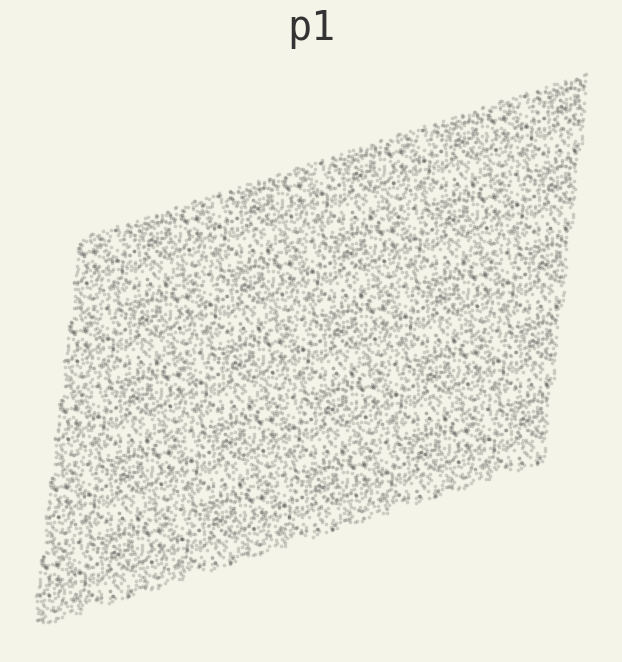

In [741]:
# make a movie

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

data = []
titles = []
for k,v in wallpaper.items():
    data.append(generate_points(x, basis, v))
    titles.append(k)
    
# make it loop
data.append(data[0])
titles.append(titles[0])
def CubicEaseInOut(p):
    if (p < 0.5):
        return 4 * p * p * p
    else:
        f = ((2 * p) - 2)
        return 0.5 * f * f * f + 1

scale = 2
duration = (len(data) - 1) * scale
dpi = 90
fig, ax = plt.subplots(figsize=(800 / dpi, 800 / dpi), dpi=dpi)
points = ax.plot(data[0][:,0], data[1][:,1], color='#333333', marker='.', markeredgewidth=0.0, linestyle='None', alpha=0.2)[0]
ax.set_facecolor('#f5f4e9')
fig.patch.set_facecolor('#f5f4e9')
title = ax.set_title('', fontsize=32, color='#333333',fontname='monospace')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.axis('off')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)
#plt.tight_layout()
def make_frame(t):
    t /= scale
    s = t % 1
    if s < 0.25:
        s = CubicEaseInOut(s * 4)
    else:
        s = 1
    i = int(t) + 1
    p = data[i] * s + (1 - s) * data[i - 1]
    title.set_text(titles[i])
    points.set_data(p[:,0], p[:,1])
    ax.set_facecolor('#f5f4e9')
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.write_gif('matplotlib.gif', fps=15)

